In [1]:
import os
import cv2
def check_images( s_dir, ext_list):
    bad_images=[]
    bad_ext=[]
    s_list= os.listdir(s_dir)
    for klass in s_list:
        klass_path=os.path.join (s_dir, klass)
        print ('processing class directory ', klass)
        if os.path.isdir(klass_path):
            file_list=os.listdir(klass_path)
            for f in file_list:               
                f_path=os.path.join (klass_path,f)
                index=f.rfind('.')
                ext=f[index+1:].lower()
                if ext not in ext_list:
                    print('file ', f_path, ' has an invalid extension ', ext)
                    bad_ext.append(f_path)
                if os.path.isfile(f_path):
                    try:
                        img=cv2.imread(f_path)
                        shape=img.shape
                    except:
                        print('file ', f_path, ' is not a valid image file')
                        bad_images.append(f_path)
                else:
                    print('*** fatal error, you a sub directory ', f, ' in class directory ', klass)
        else:
            print ('*** WARNING*** you have files in ', s_dir, ' it should only contain sub directories')
    return bad_images, bad_ext

source_dir ='TestData'
good_exts=['jpg', 'png', 'jpeg', 'gif', 'bmp' ] # list of acceptable extensions
bad_file_list, bad_ext_list=check_images(source_dir, good_exts)
if len(bad_file_list) !=0:
    print('improper image files are listed below')
    for i in range (len(bad_file_list)):
        print (bad_file_list[i])
else:
    print(' no improper image files were found')

processing class directory  .DS_Store
*** WARNING*** you have files in  TestData  it should only contain sub directories
processing class directory  JPGImages
processing class directory  Annotations
file  TestData/Annotations/Image10.xml  has an invalid extension  xml
file  TestData/Annotations/Image10.xml  is not a valid image file
file  TestData/Annotations/Image1.xml  has an invalid extension  xml
file  TestData/Annotations/Image1.xml  is not a valid image file
file  TestData/Annotations/Image2.xml  has an invalid extension  xml
file  TestData/Annotations/Image2.xml  is not a valid image file
file  TestData/Annotations/Image3.xml  has an invalid extension  xml
file  TestData/Annotations/Image3.xml  is not a valid image file
improper image files are listed below
TestData/Annotations/Image10.xml
TestData/Annotations/Image1.xml
TestData/Annotations/Image2.xml
TestData/Annotations/Image3.xml


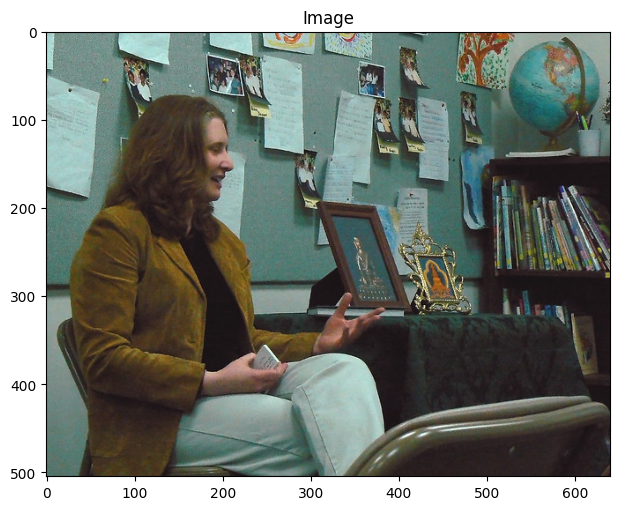

In [2]:
import matplotlib.pyplot as plt
from torchvision.io import read_image


image = read_image("TestData/JPGImages/image1.jpg")

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))

In [46]:
from torchvision.transforms import v2 as T

def get_transform(train):
    transforms = []
    if train:
        # transforms.append(T.RandomResizedCrop(size=(224, 224), antialias=True))
        transforms.append(T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)))
        # transforms.append(T.RandomPhotometricDistort(0.5))
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    # transforms.append(T.TenCrop(32)) # this is a tuple of PIL Images
    # transforms.append(T.Lambda(lambda crops: torch.stack([T.PILToTensor()(crop) for crop in crops]))),
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [51]:
import os
import torch
import numpy as np
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
import xml.etree.ElementTree as ET

labelsMaster = ["bg", "Musical keyboard", "Piano", "Wheel", "Car", "Mirror", "Clothing", "Chair", "Ladder", "Music stand", "Table", "Chair", "Building (group)", "Drink (group)", "Shelf", "Book", "Book (group)", "Camera", "Drink", "Desk", "Human arm", "Human hair", "Human leg", "Human hand", "Watch", "Screen", "Woman"]


def read_pascal_voc_annotation(xml_file):
    # tree = ET.parse(xml_file, parser = ET.XMLParser(encoding = 'iso-8859-5'))
    print(xml_file)
    tree = ET.parse(xml_file)

    root = tree.getroot()

    annotations = []
    for obj in root.findall('object'):
        bbox = obj.find('bndbox')
        xmin = float(bbox.find('xmin').text)
        ymin = float(bbox.find('ymin').text)
        xmax = float(bbox.find('xmax').text)
        ymax = float(bbox.find('ymax').text)
        label = obj.find('name').text

        annotations.append({
            'bbox': [xmin, ymin, xmax, ymax],
            'label': label
        })

    return annotations

# print(read_pascal_voc_annotation('TestData/Annotations/image10.xml'))

class TestDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "JPGImages"))))
        self.annotations = list(sorted(os.listdir(os.path.join(root, "Annotations"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "JPGImages", self.imgs[idx])
        annotation_path = os.path.join(self.root, "Annotations", self.annotations[idx])
        img = read_image(img_path)
        
        annotation_out = read_pascal_voc_annotation(annotation_path)

        # instances are encoded as different colors
        # obj_ids = torch.unique(img)
        # first id is the background, so remove it
        # obj_ids = obj_ids[1:]
        num_objs = len(annotation_out)

        print(num_objs)

        # split the color-encoded mask into a set
        # of binary masks
        # masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        # boxes = masks_to_boxes(masks)
        boxesList = [a["bbox"] for a in annotation_out]
        boxes = torch.tensor(np.array(boxesList), dtype=float)

        # there is only one class
        # labels = torch.ones((num_objs,), dtype=torch.int64)

        labelList = [labelsMaster.index(a["label"]) for a in annotation_out]
        
        tensorLabel = torch.tensor(np.array(labelList), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["labels"] = tensorLabel
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [5]:
# import torchvision
# from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


# def get_model_instance_segmentation(num_classes):
#     # load an instance segmentation model pre-trained on COCO
#     model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

#     # get number of input features for the classifier
#     in_features = model.roi_heads.box_predictor.cls_score.in_features
#     # replace the pre-trained head with a new one
#     model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

#     # # now get the number of input features for the mask classifier
#     # in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
#     # hidden_layer = 256
#     # # and replace the mask predictor with a new one
#     # model.roi_heads.mask_predictor = MaskRCNNPredictor(
#     #     in_features_mask,
#     #     hidden_layer,
#     #     num_classes
#     # )

#     return model

In [22]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

model = get_model_instance_segmentation(len(labelsMaster))


In [47]:
import math
import utils
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from engine import train_one_epoch, evaluate


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

dataset = TestDataset('TestData', get_transform(train=True))
dataset_test = TestDataset('TestData', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[0:2])
dataset_test = torch.utils.data.Subset(dataset_test, indices[2:4])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn
)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq, scaler=None):
#     model.train()
#     metric_logger = utils.MetricLogger(delimiter="  ")
#     metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
#     header = f"Epoch: [{epoch}]"

#     lr_scheduler = None
#     if epoch == 0:
#         warmup_factor = 1.0 / 1000
#         warmup_iters = min(1000, len(data_loader) - 1)

#         lr_scheduler = torch.optim.lr_scheduler.LinearLR(
#             optimizer, start_factor=warmup_factor, total_iters=warmup_iters
#         )

#     for images, targets in metric_logger.log_every(data_loader, print_freq, header):
#         images = list(image.to(device) for image in images)
#         targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
#         with torch.cuda.amp.autocast(enabled=scaler is not None):
#             loss_dict = model(images, targets)
#             losses = sum(loss for loss in loss_dict.values())

#         # reduce losses over all GPUs for logging purposes
#         loss_dict_reduced = utils.reduce_dict(loss_dict)
#         losses_reduced = sum(loss for loss in loss_dict_reduced.values())

#         loss_value = losses_reduced.item()

#         if not math.isfinite(loss_value):
#             print(f"Loss is {loss_value}, stopping training")
#             print(loss_dict_reduced)
#             sys.exit(1)

#         optimizer.zero_grad()
#         if scaler is not None:
#             scaler.scale(losses).backward()
#             scaler.step(optimizer)
#             scaler.update()
#         else:
#             losses.backward()
#             optimizer.step()

#         if lr_scheduler is not None:
#             lr_scheduler.step()

#         metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
#         metric_logger.update(lr=optimizer.param_groups[0]["lr"])

#     return metric_logger

# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
# epoch_number = 0

# EPOCHS = 5

# best_vloss = 1_000_000.

model.to(device)
num_epochs = 5

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
#     # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

# torch.save(model.state_dict(), 'test_finetune_weights.pth')
print("That's it!")

TestData/Annotations/Image10.xml
6
TestData/Annotations/Image3.xml
6


/var/folders/12/lgww1w4s6j31rwtyn8g5db7m0000gn/T/ipykernel_31000/2008310327.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [0/1]  eta: 0:00:10  lr: 0.000005  loss: 4.2549 (4.2549)  loss_classifier: 3.4045 (3.4045)  loss_box_reg: 0.7916 (0.7916)  loss_objectness: 0.0182 (0.0182)  loss_rpn_box_reg: 0.0406 (0.0406)  time: 10.7566  data: 0.1508
Epoch: [0] Total time: 0:00:10 (10.7585 s / it)
TestData/Annotations/Image1.xml
13
TestData/Annotations/Image10.xml
6
TestData/Annotations/Image2.xml
7
TestData/Annotations/Image3.xml
6
creating index...
index created!
TestData/Annotations/Image1.xml
13
Test:  [0/2]  eta: 0:00:03  model_time: 1.6053 (1.6053)  evaluator_time: 0.0035 (0.0035)  time: 1.6114  data: 0.0025
TestData/Annotations/Image2.xml
7
Test:  [1/2]  eta: 0:00:01  model_time: 1.6053 (1.6269)  evaluator_time: 0.0015 (0.0025)  time: 1.6316  data: 0.0022
Test: Total time: 0:00:03 (1.6318 s / it)
Averaged stats: model_time: 1.6053 (1.6269)  evaluator_time: 0.0015 (0.0025)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | m

tensor([0.1542, 0.1373, 0.1213, 0.1204, 0.1179, 0.1162, 0.1160, 0.1157, 0.1136,
        0.1130, 0.1117, 0.1110, 0.1109, 0.1104, 0.1095, 0.1087, 0.1084, 0.1082,
        0.1071, 0.1070, 0.1065, 0.1064, 0.1061, 0.1042, 0.1039, 0.1028, 0.1021,
        0.1013, 0.1013, 0.1006, 0.1003, 0.0999, 0.0988, 0.0986, 0.0985, 0.0981,
        0.0980, 0.0975, 0.0975, 0.0973, 0.0972, 0.0972, 0.0966, 0.0959, 0.0955,
        0.0954, 0.0953, 0.0946, 0.0945, 0.0945, 0.0934, 0.0933, 0.0932, 0.0931,
        0.0930, 0.0929, 0.0929, 0.0925, 0.0925, 0.0921, 0.0920, 0.0919, 0.0909,
        0.0908, 0.0907, 0.0899, 0.0897, 0.0896, 0.0895, 0.0893, 0.0892, 0.0892,
        0.0891, 0.0889, 0.0883, 0.0883, 0.0882, 0.0882, 0.0881, 0.0881, 0.0878,
        0.0875, 0.0871, 0.0869, 0.0867, 0.0864, 0.0864, 0.0861, 0.0860, 0.0859,
        0.0855, 0.0855, 0.0849, 0.0848, 0.0847, 0.0847, 0.0845, 0.0844, 0.0842,
        0.0842])


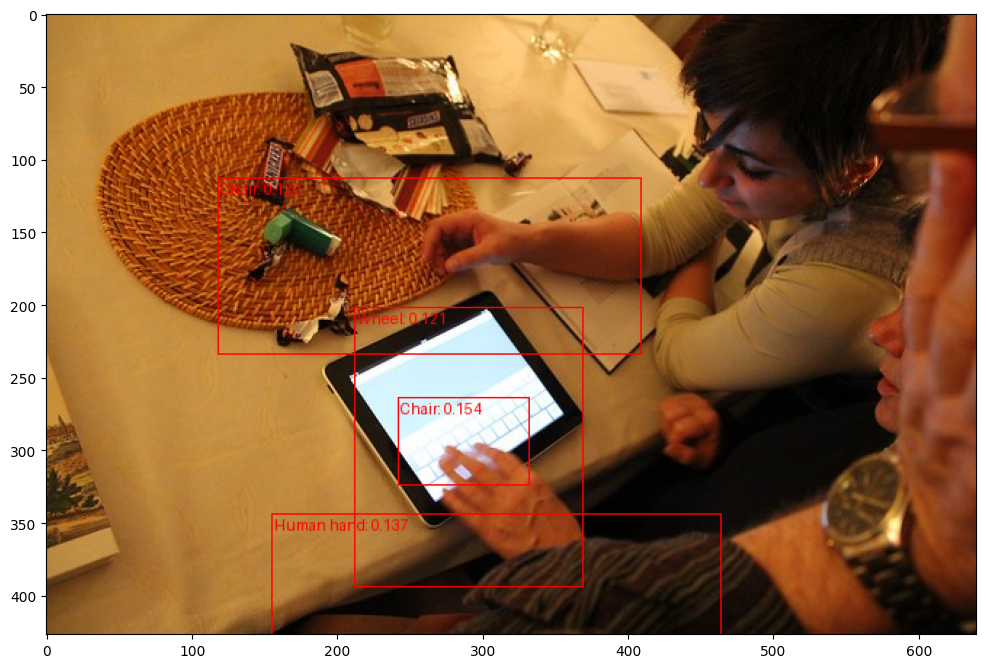

In [52]:
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


# image = read_image("PennFudanPed/PNGImages/PennPed00096.png")
image = read_image("TestData/JPGImages/image10.jpg")
eval_transform = get_transform(train=False)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# model = get_model_instance_segmentation(2)
# model.load_state_dict(torch.load("pdp_finetune_weights.pth", weights_only=True))
# model.eval()

with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    print(predictions[0]["scores"])
    predRaw = predictions[0]

idxOfClass = [i for i, x in enumerate(list(predRaw['scores'])) if x > 0.12]
# print(idxOfClass)
# pred = {'boxes': predRaw['boxes'][idxOfClass],'labels': predRaw['labels'][idxOfClass],'masks': predRaw['masks'][idxOfClass],'scores': predRaw['scores'][idxOfClass]}

pred = {'boxes': predRaw['boxes'][idxOfClass],'labels': predRaw['labels'][idxOfClass],'scores': predRaw['scores'][idxOfClass]}

image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"{labelsMaster[label]}: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
# pred_labels = [f"person"]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

# masks = (pred["masks"] > 0.7).squeeze(1)
# output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))